In [52]:
import matplotlib.pyplot as plt

# Set global font size
plt.rcParams.update({'font.size': 14})  # Adjust all plot text globally

Loading data...
Plotting all tree locations...


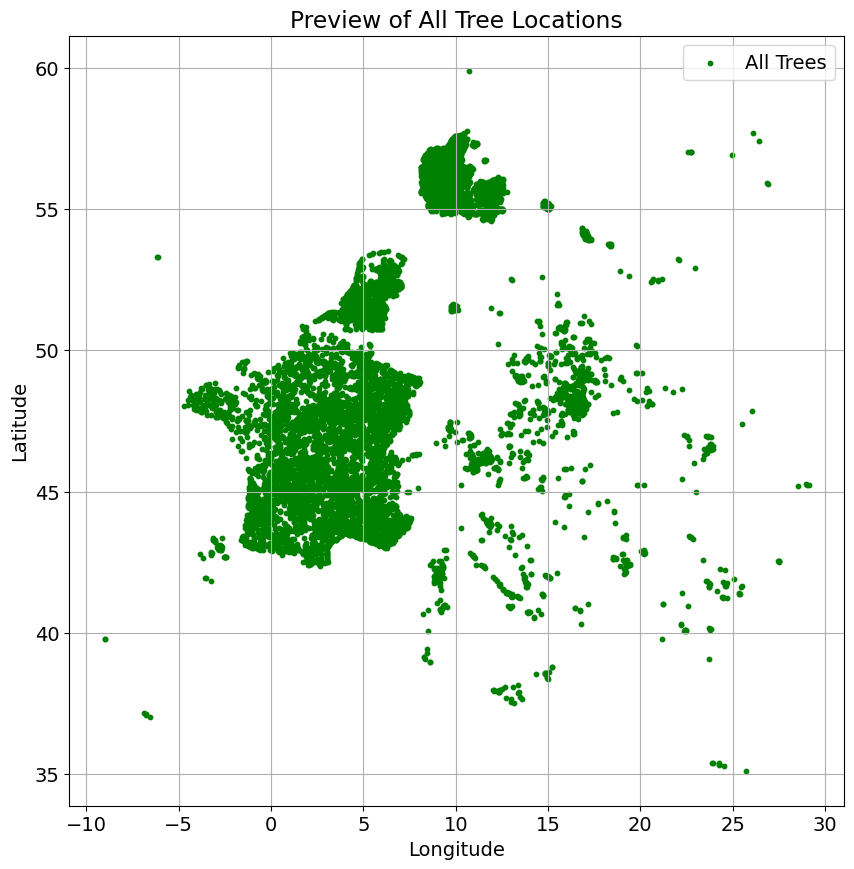


Please enter the coordinates and radius for the area of interest:

Analyzing specified area...


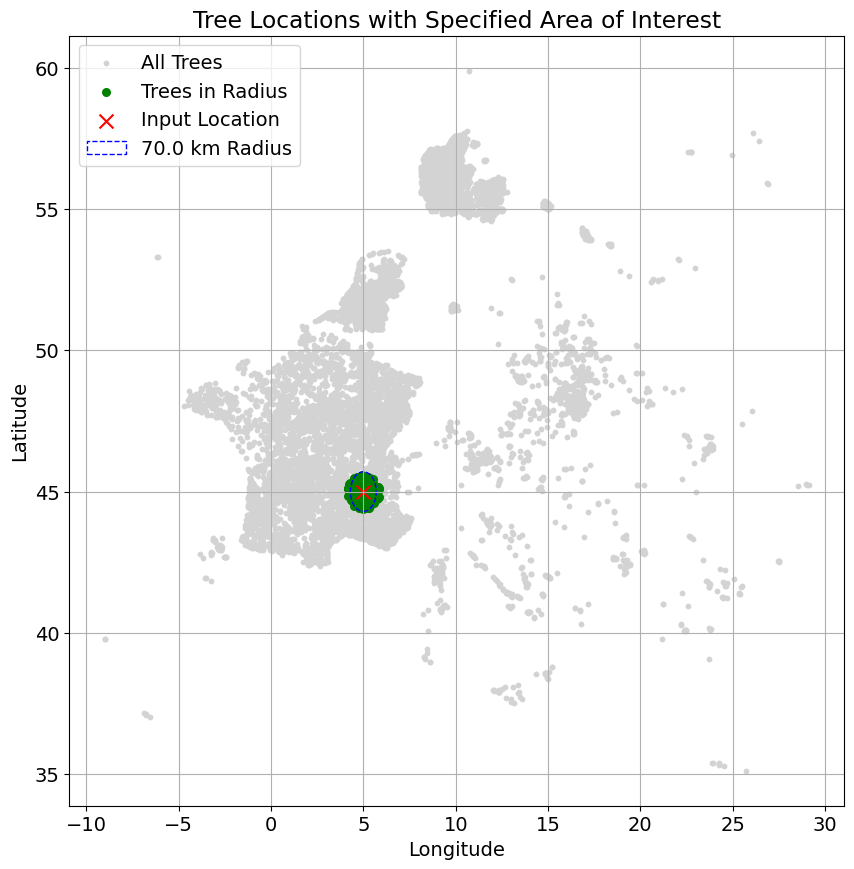


Calculating criteria weights...
Criteria Weights: {'AQI_Impact': 0.4, 'Species_Importance': 0.35, 'Tree_Density': 0.25}

Ranking trees for potential removal...
Number of trees selected for removal: 13

Recommended Trees for Removal:
Location: (45.15981, 5.77312), Species ID: [8424.0, 10073.0, 10896.0, 5412.0, 10228.0, 4871.0, 1215.0, 694.0, 8549.0, 3020.0, 963.0, 4102.0, 5335.0, 3935.0, 8807.0, 6689.0, 868.0, 4238.0, 11120.0, 8106.0, 10664.0, 10991.0, 6331.0, 799.0, 1888.0, 146.0, 11140.0, 3457.0, 2109.0, 9388.0, 5542.0, 8917.0, 8770.0, 2474.0, 9028.0, 855.0, 10315.0, 7504.0, 9190.0, 1497.0, 2122.0, 1677.0, 4854.0, 981.0, 53.0, 10909.0, 6788.0, 10367.0, 7862.0, 569.0, 6143.0, 423.0, 8705.0, 5860.0, 6909.0, 5520.0, 5022.0, 10427.0, 5557.0, 6925.0, 544.0, 8208.0, 9647.0, 4795.0, 2570.0, 9261.0, 7971.0, 10385.0]
Location: (45.03321, 5.7907), Species ID: [6461.0, 4558.0, 2142.0, 3594.0, 5656.0, 2678.0, 811.0, 5335.0, 10896.0, 11178.0, 981.0, 2885.0, 10956.0, 7666.0, 1986.0, 8424.0, 53.0, 

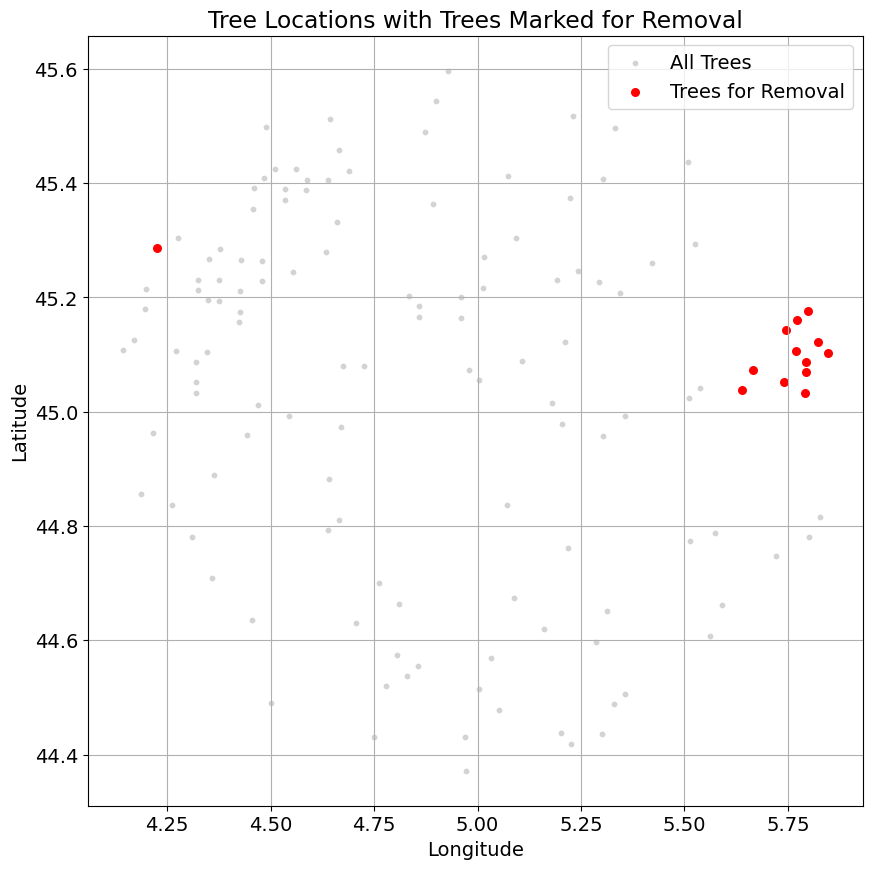


Analysis complete!


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from geopy.distance import geodesic

def load_data():
    merged_data = pd.read_csv('cluster_with_pollution_data.csv')
    merged_data['coordinates_lon'] = merged_data['coordinates_lon'].apply(eval)
    merged_data['coordinates_lat'] = merged_data['coordinates_lat'].apply(eval)
    merged_data['speciesId'] = merged_data['speciesId'].apply(eval)
    merged_data['distance_to_urban'] = merged_data.apply(lambda row: calculate_distance_to_urban(row), axis=1)
    merged_data['distance_to_water'] = merged_data.apply(lambda row: calculate_distance_to_water(row), axis=1)
    return merged_data

def calculate_distance_to_urban(row):
    urban_location = (42.0, -0.5)
    return geodesic((row['average_lat'], row['average_lon']), urban_location).km

def calculate_distance_to_water(row):
    water_location = (42.2, -0.7)
    return geodesic((row['average_lat'], row['average_lon']), water_location).km

def calculate_criteria(df):
    if 'AQI_Impact' not in df.columns:
        df['AQI_Impact'] = 0.4 * df['AQI'] + 0.2 * df['CO'] + 0.2 * df['NO2'] + 0.2 * df['PM2.5']
    if 'Species_Importance' not in df.columns:
        df['Species_Importance'] = df['speciesId'].apply(lambda x: len(set(x)))
    if 'Tree_Density' not in df.columns:
        df['Tree_Density'] = df['coordinates_lon'].apply(len)
    return df

def plot_all_tree_locations(df):
    plt.figure(figsize=(10, 10))
    plt.scatter(df['average_lon'], df['average_lat'], c='green', s=10, label='All Trees')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Preview of All Tree Locations")
    plt.legend()
    plt.grid(True)
    plt.show()

def filter_trees_by_location(df, input_coords, radius_km):
    df = df.copy()
    df['distance_to_input'] = df.apply(
        lambda row: geodesic((row['average_lat'], row['average_lon']), input_coords).km, axis=1
    )
    return df[df['distance_to_input'] <= radius_km]

def plot_location_and_trees(df, input_coords, radius_km):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(df['average_lon'], df['average_lat'], c='lightgray', s=10, label='All Trees')
    within_radius = filter_trees_by_location(df, input_coords, radius_km)
    ax.scatter(within_radius['average_lon'], within_radius['average_lat'], c='green', s=30, label='Trees in Radius')
    ax.scatter(input_coords[1], input_coords[0], color='red', s=100, label='Input Location', marker='x')
    circle = plt.Circle((input_coords[1], input_coords[0]), radius_km/100, color='blue', fill=False, linestyle='--', label=f'{radius_km} km Radius')
    ax.add_patch(circle)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title("Tree Locations with Specified Area of Interest")
    ax.legend()
    ax.grid(True)
    plt.show()

def get_weights():
    # Modified weights to only use available criteria
    weights = {
        'AQI_Impact': 0.40,        # Environmental impact
        'Species_Importance': 0.35, # Biodiversity
        'Tree_Density': 0.25       # Forest density
    }
    print("Criteria Weights:", weights)
    return weights

def topsis_ranking(df, weights):
    # Create a copy of the dataframe
    df_result = df.copy()
    
    # Get the criteria columns
    criteria_cols = list(weights.keys())
    criteria_data = df_result[criteria_cols]
    
    # Normalize the data
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(criteria_data)
    
    # Convert weights dictionary to array in the same order as criteria_cols
    weight_array = np.array([weights[col] for col in criteria_cols])
    
    # Calculate weighted normalized decision matrix
    weighted_data = normalized_data * weight_array
    
    # Define ideal and negative-ideal solutions
    ideal_solution = np.max(weighted_data, axis=0)
    negative_ideal_solution = np.min(weighted_data, axis=0)
    
    # Calculate distances
    dist_to_ideal = np.sqrt(np.sum((weighted_data - ideal_solution) ** 2, axis=1))
    dist_to_negative_ideal = np.sqrt(np.sum((weighted_data - negative_ideal_solution) ** 2, axis=1))
    
    # Calculate TOPSIS scores
    topsis_score = dist_to_negative_ideal / (dist_to_ideal + dist_to_negative_ideal)
    
    # Add scores to dataframe
    df_result['TOPSIS_Score'] = topsis_score
    
    # Sort by TOPSIS score
    df_result = df_result.sort_values(by='TOPSIS_Score', ascending=False)
    
    # Select top 10% of trees for removal
    num_trees_to_remove = int(len(df_result) * 0.1)
    trees_to_remove = df_result.head(num_trees_to_remove)
    
    print(f"Number of trees selected for removal: {num_trees_to_remove}")
    
    # Print locations and species of recommended trees for removal
    print("\nRecommended Trees for Removal:")
    for index, row in trees_to_remove.iterrows():
        print(f"Location: ({row['average_lat']}, {row['average_lon']}), Species ID: {row['speciesId']}")
    
    # Plot results
    plt.figure(figsize=(10, 10))
    plt.scatter(df_result['average_lon'], df_result['average_lat'], c='lightgray', s=10, label='All Trees')
    plt.scatter(trees_to_remove['average_lon'], trees_to_remove['average_lat'], c='red', s=30, label='Trees for Removal')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Tree Locations with Trees Marked for Removal")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return trees_to_remove  # Return the DataFrame of trees to remove

def main():
    try:
        # Load and prepare data
        print("Loading data...")
        merged_data = load_data()
        merged_data = calculate_criteria(merged_data)
        
        # Plot initial visualization
        print("Plotting all tree locations...")
        plot_all_tree_locations(merged_data)
        
        # Get user input
        print("\nPlease enter the coordinates and radius for the area of interest:")
        input_lat = float(input("Enter latitude of the area: "))
        input_lon = float(input("Enter longitude of the area: "))
        radius_km = float(input("Enter radius around the area (in km): "))
        
        # Process the specified area
        input_coords = (input_lat, input_lon)
        print("\nAnalyzing specified area...")
        plot_location_and_trees(merged_data, input_coords, radius_km)
        trees_in_area = filter_trees_by_location(merged_data, input_coords, radius_km)
        
        if trees_in_area.empty:
            print(f"No trees found within {radius_km} km of the specified location.")
            return
        
        # Get weights and perform TOPSIS ranking
        print("\nCalculating criteria weights...")
        weights = get_weights()
        
        print("\nRanking trees for potential removal...")
        trees_to_remove = topsis_ranking(trees_in_area, weights)  # Store result here
        
        print("\nAnalysis complete!")
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()

Please enter the coordinates and radius for the area of interest:

Analyzing pollution levels in the specified area...
Criteria Weights: {'AQI_Impact': 0.4, 'Species_Importance': 0.35, 'Tree_Density': 0.25}
Number of trees selected for removal: 13

Recommended Trees for Removal:
Location: (45.15981, 5.77312), Species ID: [8424.0, 10073.0, 10896.0, 5412.0, 10228.0, 4871.0, 1215.0, 694.0, 8549.0, 3020.0, 963.0, 4102.0, 5335.0, 3935.0, 8807.0, 6689.0, 868.0, 4238.0, 11120.0, 8106.0, 10664.0, 10991.0, 6331.0, 799.0, 1888.0, 146.0, 11140.0, 3457.0, 2109.0, 9388.0, 5542.0, 8917.0, 8770.0, 2474.0, 9028.0, 855.0, 10315.0, 7504.0, 9190.0, 1497.0, 2122.0, 1677.0, 4854.0, 981.0, 53.0, 10909.0, 6788.0, 10367.0, 7862.0, 569.0, 6143.0, 423.0, 8705.0, 5860.0, 6909.0, 5520.0, 5022.0, 10427.0, 5557.0, 6925.0, 544.0, 8208.0, 9647.0, 4795.0, 2570.0, 9261.0, 7971.0, 10385.0]
Location: (45.03321, 5.7907), Species ID: [6461.0, 4558.0, 2142.0, 3594.0, 5656.0, 2678.0, 811.0, 5335.0, 10896.0, 11178.0, 981.0, 2

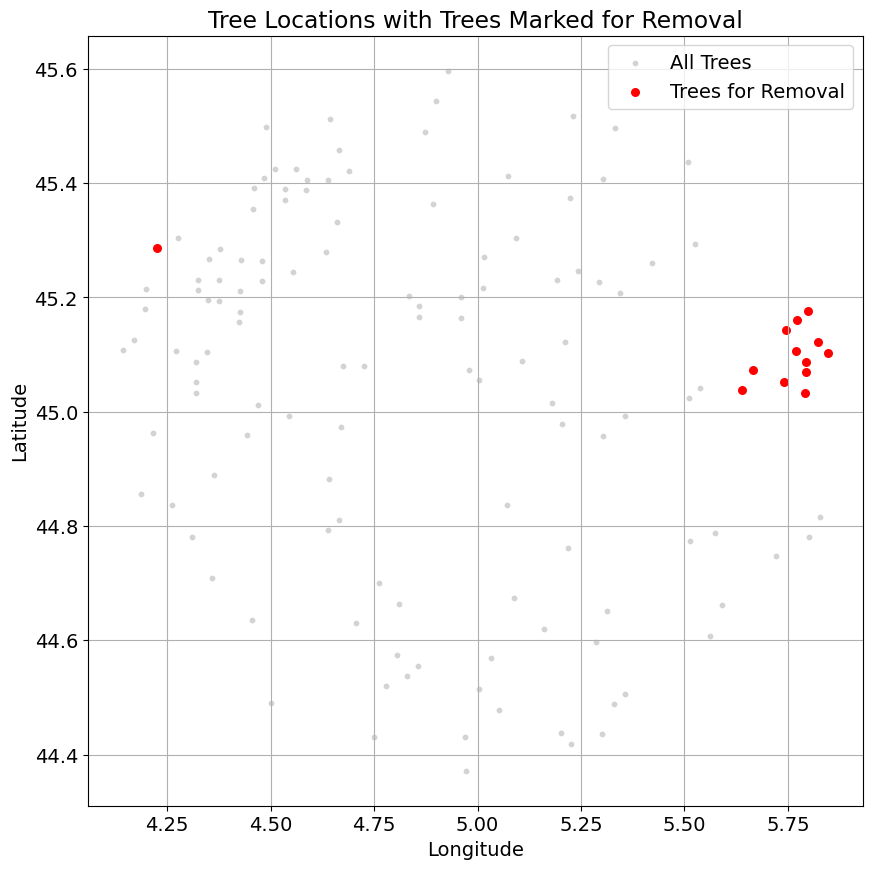

An error occurred: Colorbar.__init__() got an unexpected keyword argument 'fontsize'


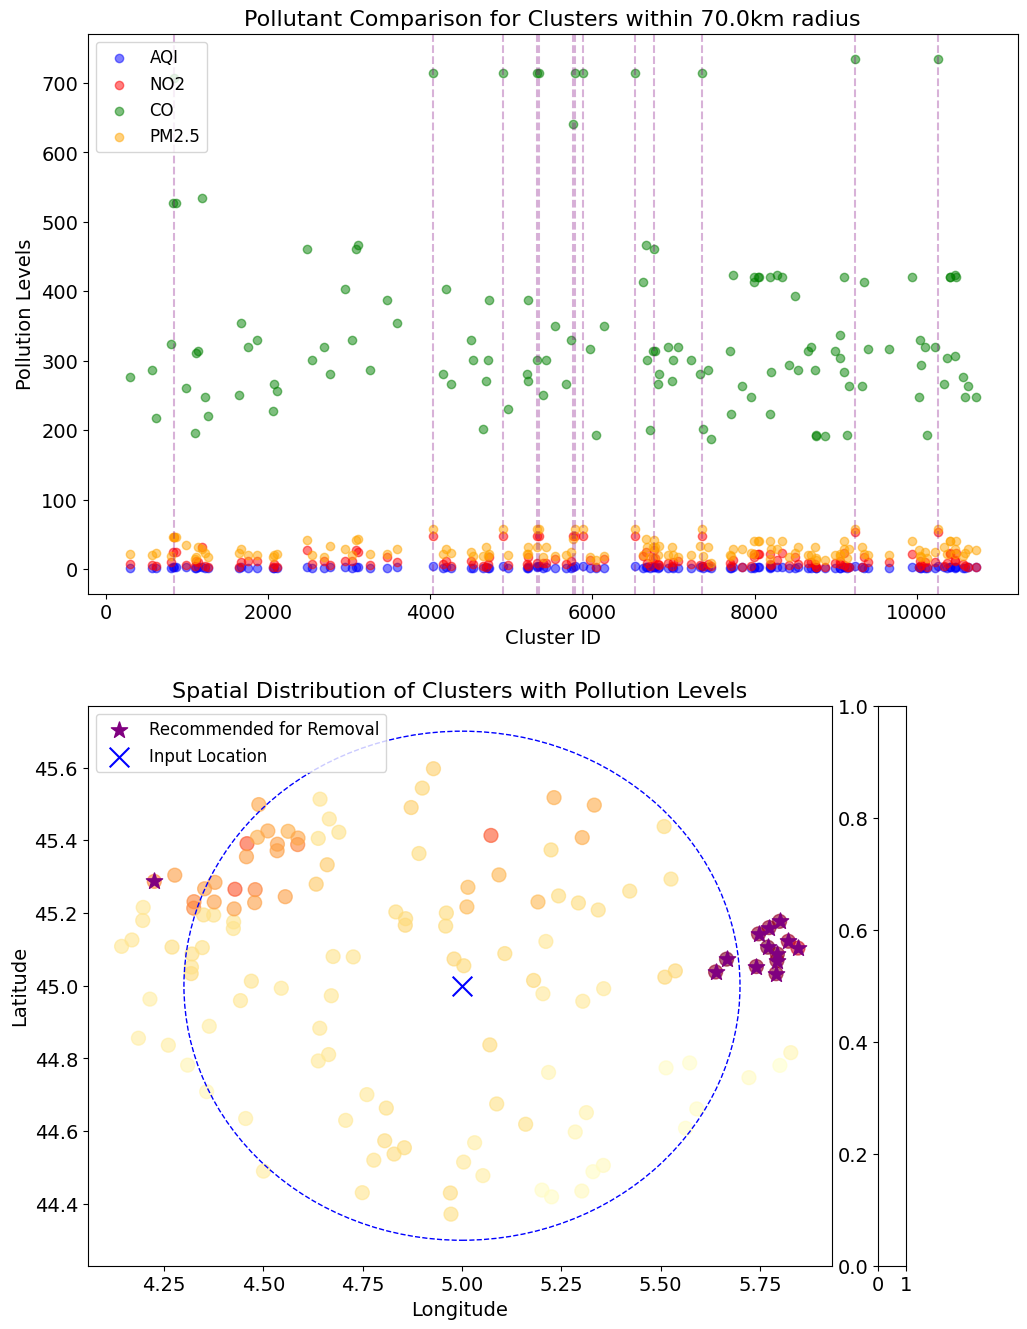

In [54]:
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import numpy as np

def find_clusters_in_radius(df, input_coords, radius_km):
    """
    Find all clusters within the specified radius of the input location
    """
    df['distance_to_input'] = df.apply(
        lambda row: geodesic((row['average_lat'], row['average_lon']), input_coords).km, axis=1
    )
    return df[df['distance_to_input'] <= radius_km]

def calculate_criteria_and_distances(df):
    """
    Calculate all criteria including distances for TOPSIS analysis
    """
    df = df.copy()
    
    # Calculate pollution impact
    if 'AQI_Impact' not in df.columns:
        df['AQI_Impact'] = 0.4 * df['AQI'] + 0.2 * df['CO'] + 0.2 * df['NO2'] + 0.2 * df['PM2.5']
    
    # Calculate species importance
    if 'Species_Importance' not in df.columns:
        df['Species_Importance'] = df['speciesId'].apply(lambda x: len(set(x)))
    
    # Calculate tree density
    if 'Tree_Density' not in df.columns:
        df['Tree_Density'] = df['coordinates_lon'].apply(len)
    
    # Calculate distances
    urban_location = (42.0, -0.5)  # Your urban center coordinates
    water_location = (42.2, -0.7)  # Your water body coordinates
    
    df['distance_to_urban'] = df.apply(
        lambda row: geodesic((row['average_lat'], row['average_lon']), urban_location).km, 
        axis=1
    )
    df['distance_to_water'] = df.apply(
        lambda row: geodesic((row['average_lat'], row['average_lon']), water_location).km, 
        axis=1
    )
    
    return df

def plot_pollutant_comparison_by_location(df, input_coords, radius_km, recommended_clusters=None):
    """
    Plot pollution comparisons for clusters within the specified radius
    """
    # Find clusters within the radius
    nearby_clusters = find_clusters_in_radius(df, input_coords, radius_km)
    
    if nearby_clusters.empty:
        print(f"No clusters found within {radius_km} km of the specified location.")
        return

    # Create figure with subplots for different visualizations
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))
    
    # Plot 1: Pollutant levels for each cluster
    clusters = nearby_clusters['cluster'].values
    aqi_values = nearby_clusters['AQI'].values
    no2_values = nearby_clusters['NO2'].values
    co_values = nearby_clusters['CO'].values
    pm25_values = nearby_clusters['PM2.5'].values
    
    # Sort all arrays based on cluster numbers for better visualization
    sort_idx = np.argsort(clusters)
    clusters = clusters[sort_idx]
    aqi_values = aqi_values[sort_idx]
    no2_values = no2_values[sort_idx]
    co_values = co_values[sort_idx]
    pm25_values = pm25_values[sort_idx]
    
    # Plot pollutant levels
    ax1.scatter(clusters, aqi_values, label='AQI', color='blue', alpha=0.5)
    ax1.scatter(clusters, no2_values, label='NO2', color='red', alpha=0.5)
    ax1.scatter(clusters, co_values, label='CO', color='green', alpha=0.5)
    ax1.scatter(clusters, pm25_values, label='PM2.5', color='orange', alpha=0.5)
    
    # Highlight recommended clusters if provided
    if recommended_clusters is not None:
        for cluster in recommended_clusters:
            ax1.axvline(x=cluster, color='purple', linestyle='--', alpha=0.3)
    
    # Increase font size for the plot
    ax1.set_xlabel('Cluster ID', fontsize=14)
    ax1.set_ylabel('Pollution Levels', fontsize=14)
    ax1.set_title(f'Pollutant Comparison for Clusters within {radius_km}km radius', fontsize=16)
    ax1.legend(loc='upper left', fontsize=12)
    
    # Calculate combined pollution impact for color mapping
    pollution_impact = (0.4 * nearby_clusters['AQI'] + 
                       0.2 * nearby_clusters['CO'] + 
                       0.2 * nearby_clusters['NO2'] + 
                       0.2 * nearby_clusters['PM2.5'])
    
    # Plot 2: Spatial distribution with pollution levels
    scatter = ax2.scatter(nearby_clusters['average_lon'], 
                         nearby_clusters['average_lat'],
                         c=pollution_impact,
                         cmap='YlOrRd',
                         s=100,
                         alpha=0.6)
    
    # Highlight recommended clusters if provided
    if recommended_clusters is not None:
        recommended_df = nearby_clusters[nearby_clusters['cluster'].isin(recommended_clusters)]
        if not recommended_df.empty:
            ax2.scatter(recommended_df['average_lon'],
                       recommended_df['average_lat'],
                       color='purple',
                       s=150,
                       marker='*',
                       label='Recommended for Removal')
    
    # Plot input location
    ax2.scatter(input_coords[1], input_coords[0], 
                color='blue', 
                s=200, 
                marker='x', 
                label='Input Location')
    
    # Draw radius circle
    circle = plt.Circle((input_coords[1], input_coords[0]), 
                       radius_km/100, 
                       color='blue', 
                       fill=False, 
                       linestyle='--')
    ax2.add_patch(circle)
    
    ax2.set_xlabel('Longitude', fontsize=14)
    ax2.set_ylabel('Latitude', fontsize=14)
    ax2.set_title('Spatial Distribution of Clusters with Pollution Levels', fontsize=16)
    ax2.legend(loc='upper left', fontsize=12)
    
    # Add colorbar
    plt.colorbar(scatter, ax=ax2, label='Pollution Impact', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nSummary Statistics for Clusters in Range:")
    print(f"Total clusters in range: {len(nearby_clusters)}")
    for pollutant in ['AQI', 'NO2', 'CO', 'PM2.5']:
        print(f"\nAverage {pollutant}: {nearby_clusters[pollutant].mean():.2f}")
        print(f"Maximum {pollutant}: {nearby_clusters[pollutant].max():.2f}")
        print(f"Minimum {pollutant}: {nearby_clusters[pollutant].min():.2f}")

def main():
    try:
        # Get user input
        print("Please enter the coordinates and radius for the area of interest:")
        input_lat = float(input("Enter latitude of the area: "))
        input_lon = float(input("Enter longitude of the area: "))
        radius_km = float(input("Enter radius around the area (in km): "))
        
        # Process the specified area
        input_coords = (input_lat, input_lon)
        
        # Load and prepare data
        print("\nAnalyzing pollution levels in the specified area...")
        
        # Get trees in the area and calculate all criteria including distances
        trees_in_area = filter_trees_by_location(merged_data, input_coords, radius_km)
        trees_in_area = calculate_criteria_and_distances(trees_in_area)  # New combined function
        
        # Get weights and perform TOPSIS ranking
        weights = get_weights()
        trees_to_remove = topsis_ranking(trees_in_area, weights)
        recommended_clusters = trees_to_remove['cluster'].unique() if not trees_to_remove.empty else None
        
        # Plot the pollution comparison
        plot_pollutant_comparison_by_location(
            merged_data,
            input_coords,
            radius_km,
            recommended_clusters
        )
        
        print("\nAnalysis complete!")
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()

In [59]:
def evaluate_removal_recommendation(merged_data, trees_to_remove, input_coords, radius_km):
    """
    Enhanced evaluation of tree removal recommendations with detailed metrics and visualizations
    
    Args:
        merged_data (pd.DataFrame): Complete dataset of trees
        trees_to_remove (pd.DataFrame): Dataset of trees recommended for removal
        input_coords (tuple): (latitude, longitude) of the center point
        radius_km (float): Radius of the area of interest in kilometers
    """
    # Filter trees within the specified radius
    trees_in_area = filter_trees_by_location(merged_data, input_coords, radius_km)
    remaining_trees = trees_in_area[~trees_in_area.index.isin(trees_to_remove.index)]
    
    # Calculate basic metrics
    total_trees = len(trees_in_area)
    trees_selected = len(trees_to_remove)
    
    print("\n=== Basic Metrics ===")
    print(f"Total Trees in Area: {total_trees}")
    print(f"Trees Selected for Removal: {trees_selected}")
    print(f"Removal Percentage: {(trees_selected/total_trees * 100):.2f}%")
    
    # Environmental Impact Analysis
    print("\n=== Environmental Impact ===")
    original_aqi = trees_in_area['AQI'].mean()
    new_aqi = remaining_trees['AQI'].mean()
    print(f"Original Average AQI Impact: {original_aqi:.2f}")
    print(f"New Average AQI Impact: {new_aqi:.2f}")
    print(f"AQI Impact Change: {((new_aqi - original_aqi)/original_aqi * 100):.2f}%")
    
    # Biodiversity Impact
    all_species = set()
    for species_list in trees_in_area['speciesId']:
        all_species.update(species_list)
    
    removal_species = set()
    for species_list in trees_to_remove['speciesId']:
        removal_species.update(species_list)
    
    remaining_species = set()
    for species_list in remaining_trees['speciesId']:
        remaining_species.update(species_list)
    
    print("\n=== Biodiversity Impact ===")
    print(f"Original Unique Species: {len(all_species)}")
    print(f"Species Affected by Removal: {len(removal_species)}")
    print(f"Remaining Unique Species: {len(remaining_species)}")
    print(f"Species Diversity Change: {((len(remaining_species) - len(all_species))/len(all_species) * 100):.2f}%")
    
    # Spatial Distribution Analysis
    from scipy.spatial.distance import pdist
    if len(trees_to_remove) > 1:
        coords = trees_to_remove[['average_lat', 'average_lon']].values
        avg_distance = pdist(coords).mean()
        
        print("\n=== Spatial Distribution ===")
        print(f"Average Distance Between Selected Trees: {avg_distance:.4f} degrees")
        
        area = (trees_in_area['average_lat'].max() - trees_in_area['average_lat'].min()) * \
               (trees_in_area['average_lon'].max() - trees_in_area['average_lon'].min())
        density = len(trees_to_remove) / area if area > 0 else 0
        print(f"Cluster Density: {density:.6f}")
    
    # Create enhanced visualization plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Enhanced Environmental Impact (Top Left)
    metrics = ['AQI', 'NO2', 'CO', 'PM2.5']
    removal_means = [trees_to_remove[metric].mean() for metric in metrics]
    remaining_means = [remaining_trees[metric].mean() for metric in metrics]
    original_means = [trees_in_area[metric].mean() for metric in metrics]
    
    x = np.arange(len(metrics))
    width = 0.25
    
    axes[0,0].bar(x - width, original_means, width, label='Original', color='green', alpha=0.6)
    axes[0,0].bar(x, removal_means, width, label='Removed', color='red', alpha=0.6)
    axes[0,0].bar(x + width, remaining_means, width, label='Remaining', color='blue', alpha=0.6)
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(metrics)
    axes[0,0].set_title('Environmental Impact Analysis')
    axes[0,0].legend()
    
    # 2. Species and Tree Distribution (Top Right)
    labels = ['Original', 'Removed', 'Remaining']
    species_counts = [len(all_species), len(removal_species), len(remaining_species)]
    tree_counts = [len(trees_in_area), len(trees_to_remove), len(remaining_trees)]
    
    ax2 = axes[0,1].twinx()
    axes[0,1].bar(np.arange(len(labels)), species_counts, alpha=0.6, color='green', label='Species')
    ax2.plot(np.arange(len(labels)), tree_counts, 'r-', marker='o', label='Trees')
    
    axes[0,1].set_xticks(np.arange(len(labels)))
    axes[0,1].set_xticklabels(labels)
    axes[0,1].set_title('Species and Tree Distribution')
    axes[0,1].set_ylabel('Number of Species')
    ax2.set_ylabel('Number of Trees')
    
    # Combine legends
    lines1, labels1 = axes[0,1].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2)
    
    # 3. Spatial Distribution Heat Map (Bottom Left)
    from scipy.stats import gaussian_kde
    
    xy_original = np.vstack([trees_in_area['average_lon'], trees_in_area['average_lat']])
    z_original = gaussian_kde(xy_original)(xy_original)
    
    xy_removal = np.vstack([trees_to_remove['average_lon'], trees_to_remove['average_lat']])
    z_removal = gaussian_kde(xy_removal)(xy_removal) if len(trees_to_remove) > 1 else np.zeros_like(trees_to_remove['average_lon'])
    
    scatter1 = axes[1,0].scatter(trees_in_area['average_lon'], trees_in_area['average_lat'], 
                                c=z_original, cmap='viridis', alpha=0.6, label='All Trees')
    scatter2 = axes[1,0].scatter(trees_to_remove['average_lon'], trees_to_remove['average_lat'],
                                c='red', alpha=0.4, label='Removal Trees')
    
    axes[1,0].set_title('Spatial Distribution Density')
    axes[1,0].legend()
    
    # 4. Additional Environmental Impact Analysis (Bottom Right)
    pollution_changes = []
    metrics_extended = ['AQI', 'NO2', 'CO', 'PM2.5']
    for metric in metrics_extended:
        orig_val = trees_in_area[metric].mean()
        new_val = remaining_trees[metric].mean()
        change = ((new_val - orig_val)/orig_val * 100)
        pollution_changes.append(change)
    
    axes[1,1].bar(metrics_extended, pollution_changes, color=['red' if x > 0 else 'green' for x in pollution_changes])
    axes[1,1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[1,1].set_title('Environmental Impact Changes')
    axes[1,1].set_ylabel('Percent Change (%)')
    
    plt.tight_layout()
    plt.show()

    # Additional Environmental Analysis
    print("\n=== Detailed Environmental Impact ===")
    for metric, change in zip(metrics_extended, pollution_changes):
        print(f"{metric} Change: {change:.2f}%")

# Modify the main() function to include evaluation
def main():
    try:
        # Load and prepare data
        print("Loading data...")
        merged_data = load_data()
        merged_data = calculate_criteria(merged_data)
        
        # Plot initial visualization
        print("Plotting all tree locations...")
        plot_all_tree_locations(merged_data)
        
        # Get user input
        print("\nPlease enter the coordinates and radius for the area of interest:")
        input_lat = float(input("Enter latitude of the area: "))
        input_lon = float(input("Enter longitude of the area: "))
        radius_km = float(input("Enter radius around the area (in km): "))
        
        # Process the specified area
        input_coords = (input_lat, input_lon)
        print("\nAnalyzing specified area...")
        plot_location_and_trees(merged_data, input_coords, radius_km)
        trees_in_area = filter_trees_by_location(merged_data, input_coords, radius_km)
        
        if trees_in_area.empty:
            print(f"No trees found within {radius_km} km of the specified location.")
            return
        
        # Get weights and perform TOPSIS ranking
        print("\nCalculating criteria weights...")
        weights = get_weights()
        
        print("\nRanking trees for potential removal...")
        trees_to_remove = topsis_ranking(trees_in_area, weights)
        
        # Add evaluation
        print("\nEvaluating recommendations...")
        evaluate_removal_recommendation(merged_data, trees_to_remove, input_coords, radius_km)
        
        print("\nAnalysis complete!")
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")

Criteria Weights: {'AQI_Impact': 0.4, 'Species_Importance': 0.35, 'Tree_Density': 0.25}
Number of trees selected for removal: 13

Recommended Trees for Removal:
Location: (45.15981, 5.77312), Species ID: [8424.0, 10073.0, 10896.0, 5412.0, 10228.0, 4871.0, 1215.0, 694.0, 8549.0, 3020.0, 963.0, 4102.0, 5335.0, 3935.0, 8807.0, 6689.0, 868.0, 4238.0, 11120.0, 8106.0, 10664.0, 10991.0, 6331.0, 799.0, 1888.0, 146.0, 11140.0, 3457.0, 2109.0, 9388.0, 5542.0, 8917.0, 8770.0, 2474.0, 9028.0, 855.0, 10315.0, 7504.0, 9190.0, 1497.0, 2122.0, 1677.0, 4854.0, 981.0, 53.0, 10909.0, 6788.0, 10367.0, 7862.0, 569.0, 6143.0, 423.0, 8705.0, 5860.0, 6909.0, 5520.0, 5022.0, 10427.0, 5557.0, 6925.0, 544.0, 8208.0, 9647.0, 4795.0, 2570.0, 9261.0, 7971.0, 10385.0]
Location: (45.03321, 5.7907), Species ID: [6461.0, 4558.0, 2142.0, 3594.0, 5656.0, 2678.0, 811.0, 5335.0, 10896.0, 11178.0, 981.0, 2885.0, 10956.0, 7666.0, 1986.0, 8424.0, 53.0, 6788.0, 5860.0, 9647.0, 963.0, 8208.0, 9204.0, 9669.0, 2398.0, 1677.0, 24

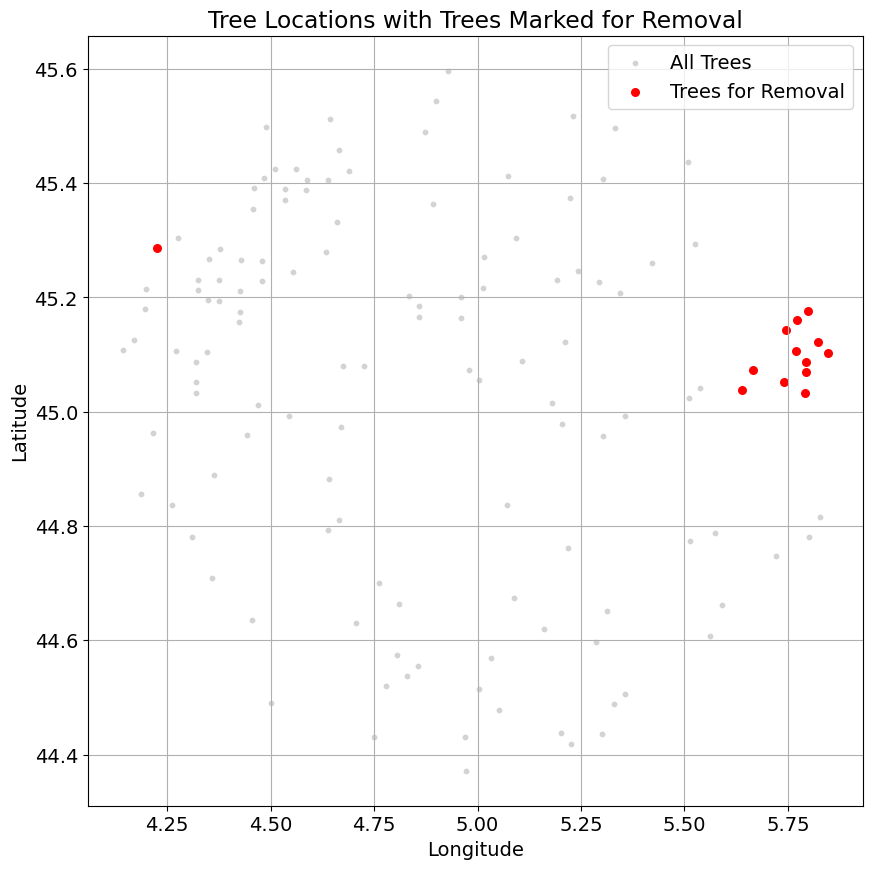


=== Basic Metrics ===
Total Trees in Area: 135
Trees Selected for Removal: 13
Removal Percentage: 9.63%

=== Environmental Impact ===
Original Average AQI Impact: 2.53
New Average AQI Impact: 2.39
AQI Impact Change: -5.24%

=== Biodiversity Impact ===
Original Unique Species: 442
Species Affected by Removal: 189
Remaining Unique Species: 407
Species Diversity Change: -7.92%

=== Spatial Distribution ===
Average Distance Between Selected Trees: 0.3206 degrees
Cluster Density: 6.231976


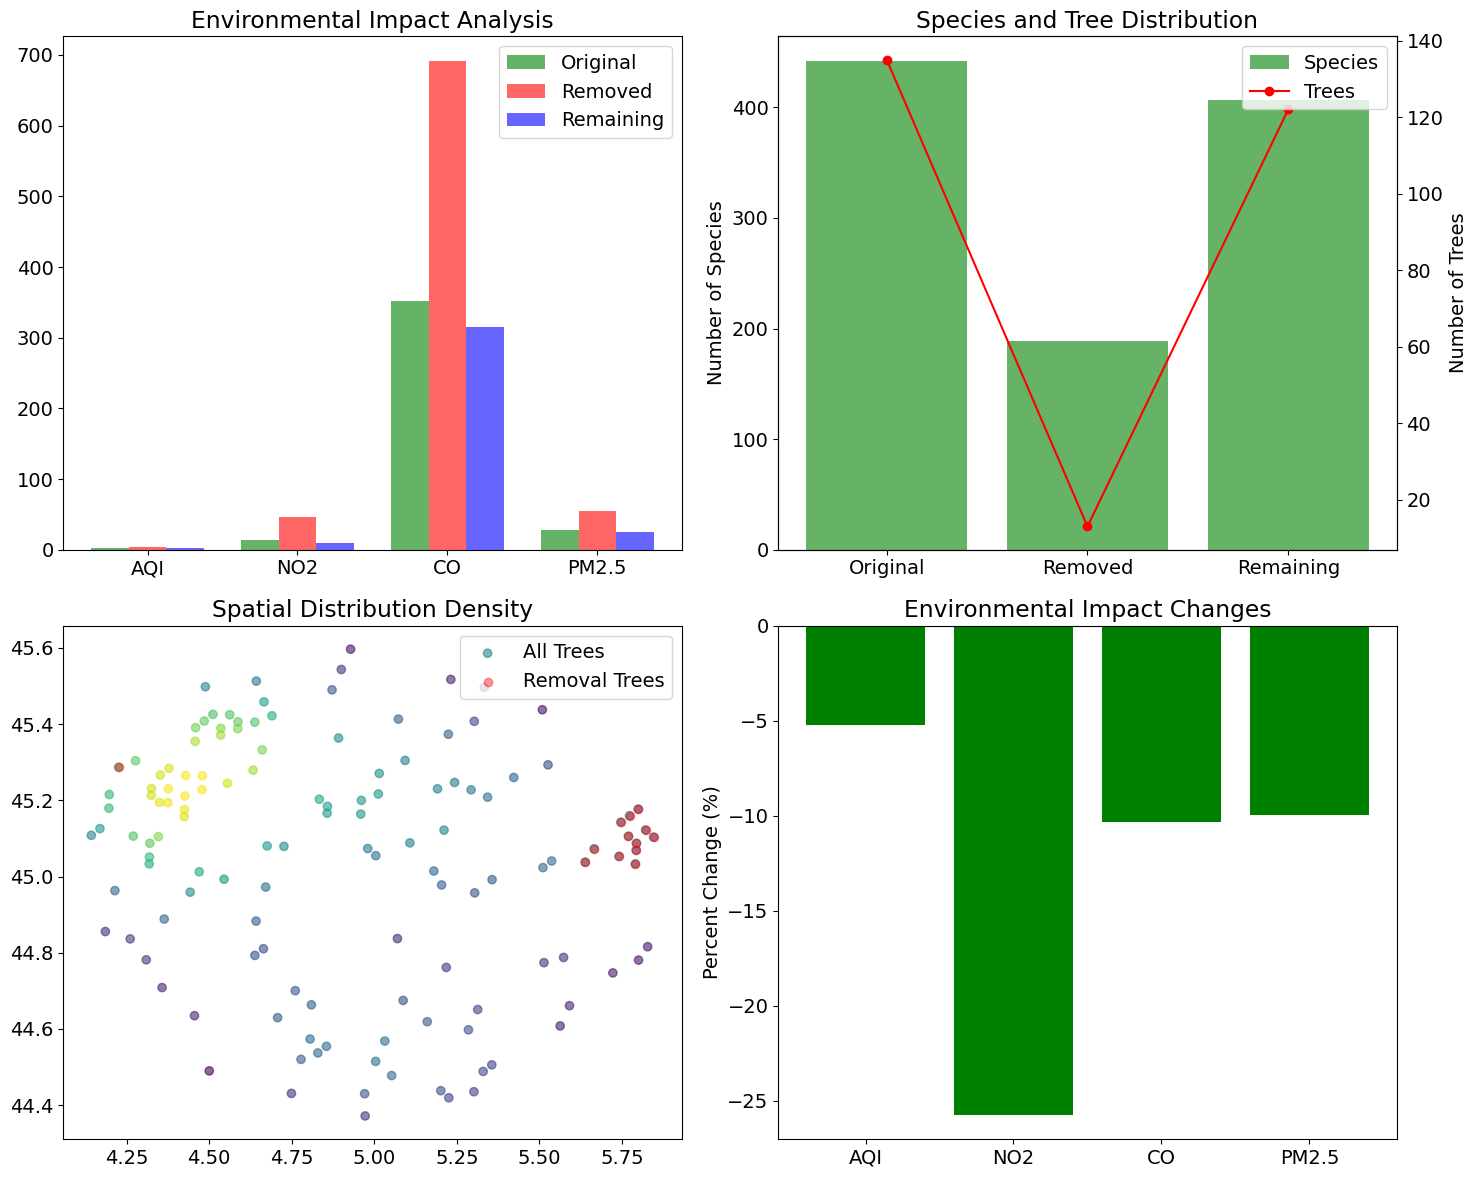


=== Detailed Environmental Impact ===
AQI Change: -5.24%
NO2 Change: -25.74%
CO Change: -10.32%
PM2.5 Change: -9.97%


In [60]:
# Load data
merged_data = load_data()
merged_data = calculate_criteria(merged_data)

# Your input parameters
input_coords = (45.0, 5)  # Example coordinates
radius_km = 70.0              # Example radius

# Get trees in area
trees_in_area = filter_trees_by_location(merged_data, input_coords, radius_km)

# Get recommendations
weights = get_weights()
trees_to_remove = topsis_ranking(trees_in_area, weights)

# Run evaluation
evaluate_removal_recommendation(merged_data, trees_to_remove, input_coords, radius_km)